---
title: "JPEG"
author: "Shreyans Jain"
date: "09/12/2023"

---

We will explore JPEG Compression in this Blog.
First we create a synthetic image of size 256*256 and we will compress it using the JPEG Algorithm.

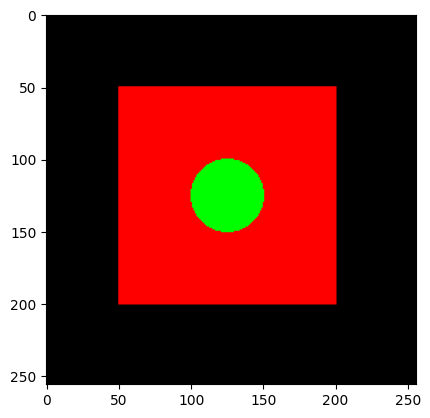

In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
width, height = 256, 256
image = Image.new("RGB", (width, height))
draw = ImageDraw.Draw(image)
draw.rectangle([50, 50, 200, 200], fill=(255, 0, 0))
draw.ellipse([100, 100, 150, 150], fill=(0, 255, 0))
image.save("synthetic_image.jpg")
plt.imshow(image)

Human eyes are more sensitive to brightness than color (Since we have more rods as compared to cones in our retina). So to achieve compression with minimal loss in percieved vision quality, we will keep the data in the intensity domain as it is and compress the data in colour domain. The intensity domain is formally called the luminosity(Y) and the colour domains are (Cb and Cr). We will first convert the image from RGB channels to YCbCr channels.

(256, 256, 3)


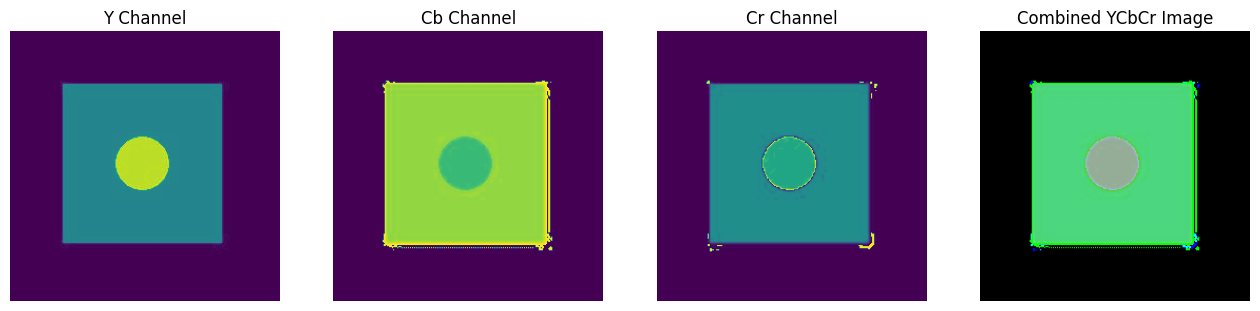

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


def rgb_to_ycbcr(rgb_image):
    rgb_array = np.array(rgb_image)
    print(rgb_array.shape)
    ycbcr_array = np.zeros(rgb_array.shape, dtype=rgb_array.dtype)
    ycbcr_array[:, :, 0] = 0.299 * rgb_array[:, :, 0] + \
        0.587 * rgb_array[:, :, 1] + 0.114 * rgb_array[:, :, 2]
    ycbcr_array[:, :, 1] = -0.169 * rgb_array[:, :, 0] - \
        0.331 * rgb_array[:, :, 1] + 0.500 * rgb_array[:, :, 2]
    ycbcr_array[:, :, 2] = 0.500 * rgb_array[:, :, 0] - \
        0.419 * rgb_array[:, :, 1] - 0.081 * rgb_array[:, :, 2]
    ycbcr_array = np.clip(ycbcr_array, 0, 255).astype(np.uint8)

    return ycbcr_array


rgb_image = Image.open("synthetic_image.jpg")

ycbcr_array = rgb_to_ycbcr(rgb_image)
# # plt.imshow(ycbcr_array)
# # plt.show()
# ycbcr_to_rgb = cv2.cvtColor(ycbcr_array, cv2.COLOR_YCrCb2RGB)

# plt.imshow(ycbcr_to_rgb)
# plt.show()
# Create subplots for Y, Cb, Cr, and Combined Image
plt.figure(figsize=(16, 4))

# Y Channel
plt.subplot(141)
plt.imshow(ycbcr_array[:, :, 0])
plt.title('Y Channel')
plt.axis('off')

# Cb Channel
plt.subplot(142)
plt.imshow(ycbcr_array[:, :, 1])
plt.title('Cb Channel')
plt.axis('off')

# Cr Channel
plt.subplot(143)
plt.imshow(ycbcr_array[:, :, 2])
plt.title('Cr Channel')
plt.axis('off')

# Combined YCbCr Image
plt.subplot(144)
plt.imshow(ycbcr_array)
plt.title('Combined YCbCr Image')
plt.axis('off')

plt.show()

Interestingly it is observed there are some artifacts at the edges of the square. This is due to Cb and Cr channels

In [3]:
# ycbcr_image = Image.open("ycbcr_image.jpg")
# image_array = np.array(ycbcr_image)
# print(image_array.shape)
y = ycbcr_array[:, :, 0]
cb = ycbcr_array[:, :, 1]
cr = ycbcr_array[:, :, 2]
# #try using opencv

In [4]:
height, width = cb.shape

## Chroma Subsampling

 Chroma subsampling involves reducing the resolution of the chrominance channels while keeping the luminance channel at full resolution


- **4:2:0 Chroma Subsampling**: Both horizontal and vertical subsampling is applied. For every two pixels in both the horizontal and vertical directions, there is one chrominance value.

We will basically take 2x2 matrix from the image channels Cb and Cr, take their average and represent it using a single pixel.



(256, 256, 3)


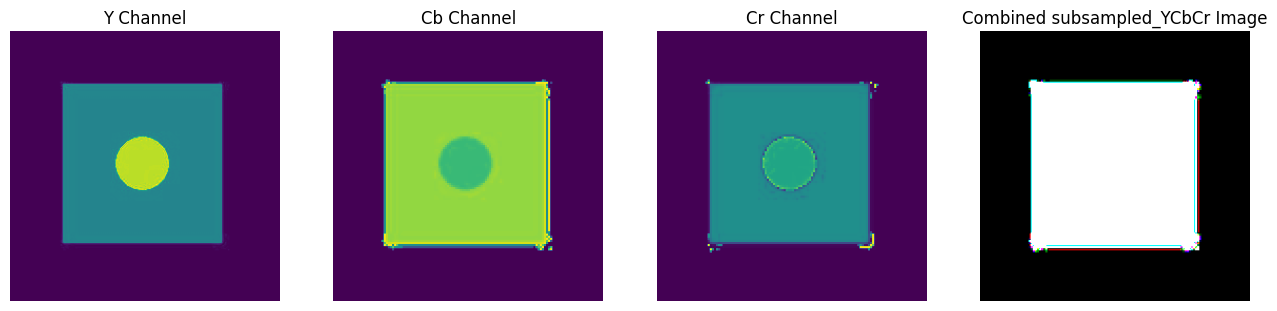

In [5]:
downsampled_cb = np.zeros((height // 2, width // 2))
downsampled_cr = np.zeros((height // 2, width // 2))
for i in range(0, height, 2):
    for j in range(0, width, 2):
        cb_avg = np.mean(cb[i:i+2, j:j+2])
        cr_avg = np.mean(cr[i:i+2, j:j+2])
        downsampled_cb[i // 2, j // 2] = cb_avg
        downsampled_cr[i // 2, j // 2] = cr_avg
upsampled_cb = np.zeros((height, width))
upsampled_cr = np.zeros((height, width))
for i in range(0, height, 2):
    for j in range(0, width, 2):
        upsampled_cb[i:i+2, j:j+2] = downsampled_cb[i // 2, j // 2]
        upsampled_cr[i:i+2, j:j+2] = downsampled_cr[i // 2, j // 2]
c_ycbcr_image = np.stack((y, upsampled_cb, upsampled_cr), axis=-1)
print(c_ycbcr_image.shape)
# plt.imshow(c_ycbcr_image)
# plt.title('c_YCbCr Image')
# plt.axis('off')
# plt.show()

plt.figure(figsize=(16, 4))

# Y Channel
plt.subplot(141)
plt.imshow(c_ycbcr_image[:, :, 0])
plt.title('Y Channel')
plt.axis('off')

# Cb Channel
plt.subplot(142)
plt.imshow(c_ycbcr_image[:, :, 1])
plt.title('Cb Channel')
plt.axis('off')

# Cr Channel
plt.subplot(143)
plt.imshow(c_ycbcr_image[:, :, 2])
plt.title('Cr Channel')
plt.axis('off')

# Combined YCbCr Image
plt.subplot(144)
plt.imshow(c_ycbcr_image)
plt.title('Combined subsampled_YCbCr Image')
plt.axis('off')

plt.show()

##DCT
DCT or Discrete Cosine Transform works on a principle similar to the fourier transform. It breaks down frequencies as a sum of cosine functions. We calculate dct coefficients for 8x8 matrices which are then represented as a weighted sum of the components.

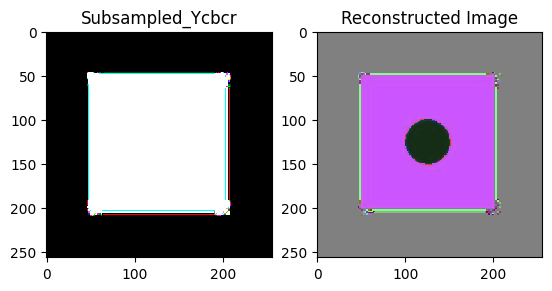

In [6]:
from scipy.fftpack import dct, idct

image = c_ycbcr_image-128
block_size = 8
dct_coefficients = np.zeros_like(image, dtype=np.float32)
for i in range(0, 256, block_size):
    for j in range(0, 256, block_size):
        block = image[i:i+block_size, j:j+block_size]
        dct_block = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
        dct_coefficients[i:i+block_size, j:j+block_size] = dct_block

# Inverse DCT to recover the original image
reconstructed_image = np.zeros_like(image, dtype=np.uint8)

for i in range(0, 256, block_size):
    for j in range(0, 256, block_size):
        dct_block = dct_coefficients[i:i+block_size, j:j+block_size]
        block = idct(idct(dct_block, axis=0, norm='ortho'),
                     axis=1, norm='ortho')
        reconstructed_image[i:i+block_size, j:j+block_size] = np.round(block)

# Display the original and reconstructed images
plt.subplot(121)
plt.imshow(c_ycbcr_image, cmap='gray', interpolation='nearest')
plt.title('Subsampled_Ycbcr')

plt.subplot(122)
plt.imshow(reconstructed_image, cmap='gray', interpolation='nearest')
plt.title('Reconstructed Image')

plt.show()
# see open cv output too

An interesting observation is that the reconstructed image after taking dct and then idct we see the appearance of the ellipse drawn in the original image which was lost after chroma subsampling. This tells us that it does not mean if we cant see something its not there but the information might be still contained.

In [7]:
normalized_dct = dct_coefficients
print(normalized_dct.shape)

(256, 256, 3)


### Quantization Tables

In this code, two quantization tables are defined: `QTy` for the luminance (Y) channel and `QTC` for the chrominance (Cb and Cr) channels. These tables play a fundamental role in quantization by specifying the values by which the DCT (Discrete Cosine Transform) coefficients are divided to achieve compression.

The luminance quantization table (`QTy`) and chrominance quantization table (`QTC`) contain specific values that determine the trade-off between image quality and compression ratio. Higher values in these tables lead to more aggressive quantization and higher compression, but at the cost of reduced image quality.

### Block-Based Quantization

The code demonstrates block-based quantization for the Y, Cb, and Cr channels separately. The code iterates through the image in 8x8 blocks, applies quantization to each block based on the corresponding quantization table, and stores the quantized values in separate arrays (`quantized_y`, `quantized_cb`, and `quantized_cr`).


### Counting Non-Zero Values

The code concludes by using `np.count_nonzero()` to count the number of non-zero values in the quantized image (`quantised`). This count represents the number of coefficients that were quantized to a non-zero value during compression, and it can provide insights into the level of compression achieved.



In [8]:
QTy = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

block_size = 8

y_channel = dct_coefficients[:, :, 0]
cb_channel = dct_coefficients[:, :, 1]
cr_channel = dct_coefficients[:, :, 2]
quantized_y = np.zeros_like(y_channel, dtype=np.float32)
quantized_cb = np.zeros_like(cb_channel, dtype=np.float32)
quantized_cr = np.zeros_like(cr_channel, dtype=np.float32)

for i in range(0, 256, block_size):
    for j in range(0, 256, block_size):
        y_block = y_channel[i:i+block_size, j:j+block_size]
        cb_block = cb_channel[i:i+block_size, j:j+block_size]
        cr_block = cr_channel[i:i+block_size, j:j+block_size]

        quantized_y_block = np.round(y_block / QTy)
        quantized_cb_block = np.round(cb_block / QTC)
        quantized_cr_block = np.round(cr_block / QTC)

        quantized_y[i:i+block_size, j:j+block_size] = quantized_y_block
        quantized_cb[i:i+block_size, j:j+block_size] = quantized_cb_block
        quantized_cr[i:i+block_size, j:j+block_size] = quantized_cr_block
quantised = np.stack((y, quantized_cb, quantized_cr), axis=-1)
print(np.count_nonzero(quantised))

28330


From 196,608 non zero values it is down to 28330 non zero values which will be further reduced in size using huffman encoding